### This file contains the post-processing code for the proposed method with different $M$ and $w_3$ settings, Proposed-E, and the baseline methods.

1. `/Reproduction/Analysis-all/MAPE/`, `/Reproduction/Analysis-all/MAE/`, and `/Reproduction/Analysis-all/MR/` contains the summary of MAPE, MAE, and MR of all methods considered . These files will be used for the statistical inference.

2. The statistical inference results will be printed out during execution. `Passed` means the corresponding null hypothesis is rejected. `Failed` means the corresponding null hypothesis cannot be rejected.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats

pd.options.mode.chained_assignment = None

In [2]:
# Get the current directory.
current_dir = os.getcwd()

# Set up random seeds for data splitting and M and w_3 values.
split_rs = [290, 150, 266, 78, 148, 133, 155, 135, 178, 241]
all_ms = [25, 50, 100, 300, 400, 500]
all_w3s = [0.5, 0.7, 0.9, 1.3, 1.5, 1.7]

os.makedirs(current_dir+'/Analysis-all/MAPE')
os.makedirs(current_dir+'/Analysis-all/MAE')
os.makedirs(current_dir+'/Analysis-all/MR')

### Summary of all results (Section 3.6.1)

In [3]:
for rs in split_rs:

    path_result_proposed = current_dir+'/Results/SA/'+str(rs)+'/'+str(rs)+'-ResultData-M200/'
    files_result_proposed = sorted(os.listdir(path_result_proposed))

    path_result_proposede = current_dir+'/Analysis-CRS/'+str(rs)+'-ResultData/'
    files_result_proposede = sorted(os.listdir(path_result_proposede))

    path_result_proposednc = current_dir+'/Results/ProposedNC/'+str(rs)+'-ResultData/'
    files_result_proposednc = sorted(os.listdir(path_result_proposednc))

    path_result_ann = current_dir+'/Results/ANN/'+str(rs)+'-ResultData/'
    files_result_ann = sorted(os.listdir(path_result_ann))

    path_result_arimar = current_dir+'/Results/ARIMAR/'+str(rs)+'-ResultData/'
    files_result_arimar = sorted(os.listdir(path_result_arimar))

    path_result_arimap = current_dir+'/Results/ARIMAP/'+str(rs)+'-ResultData/'
    files_result_arimap = sorted(os.listdir(path_result_arimap))

    path_result_naive = current_dir+'/Results/Naive/'+str(rs)+'-ResultData/'
    files_result_naive = sorted(os.listdir(path_result_naive))

    result_this_rs_mape = pd.DataFrame(np.nan, index=list(range(len(files_result_proposed))), columns=list(range(19)))
    result_this_rs_mae = pd.DataFrame(np.nan, index=list(range(len(files_result_proposed))), columns=list(range(19)))
    result_this_rs_mr = pd.DataFrame(np.nan, index=list(range(len(files_result_proposed))), columns=list(range(19)))

    for i in range(len(files_result_proposed)):

        result_this_well = pd.DataFrame()

        df_proposed = pd.read_excel(path_result_proposed+files_result_proposed[i], header = 0, sheet_name = 0)
        df_proposed = df_proposed[df_proposed['Mark'] == 'forecast'].reset_index(drop=True)
        result_this_well['True'] = df_proposed['TrueCumu']
        result_this_well['Proposed'] = df_proposed['PredCumu']                 

        for this_m in all_ms:

            path_result_this_m = current_dir+'/Results/SA/'+str(rs)+'/'+str(rs)+'-ResultData-M'+str(this_m)+'/'
            files_result_this_m = sorted(os.listdir(path_result_this_m))

            df_this_m = pd.read_excel(path_result_this_m+files_result_this_m[i], header = 0, sheet_name = 0)
            df_this_m = df_this_m[df_this_m['Mark'] == 'forecast'].reset_index(drop=True)
            result_this_well['Proposed-M'+str(this_m)] = df_this_m['PredCumu']
        
        for this_w3 in all_w3s:

            path_result_this_w3 = current_dir+'/Results/SA/'+str(rs)+'/'+str(rs)+'-ResultData-w3'+str(this_w3)+'/'
            files_result_this_w3 = sorted(os.listdir(path_result_this_w3))

            df_this_w3 = pd.read_excel(path_result_this_w3+files_result_this_w3[i], header = 0, sheet_name = 0)
            df_this_w3 = df_this_w3[df_this_w3['Mark'] == 'forecast'].reset_index(drop=True)
            result_this_well['Proposed-w3'+str(this_w3)] = df_this_w3['PredCumu']

        df_proposede = pd.read_excel(path_result_proposede+files_result_proposede[i], header = 0, sheet_name = 0)
        result_this_well['Proposed-E'] = df_proposede['Mean'] # Results from Analysis-CRS does not contain {'Mark' != 'forecast'} rows.

        df_proposednc = pd.read_excel(path_result_proposednc+files_result_proposednc[i], header = 0, sheet_name = 0)
        df_proposednc = df_proposednc[df_proposednc['Mark'] == 'forecast'].reset_index(drop=True)
        result_this_well['Proposed-NC'] = df_proposednc['PredCumu']

        df_ann = pd.read_excel(path_result_ann+files_result_ann[i], header = 0, sheet_name = 0)
        df_ann = df_ann[df_ann['Mark'] == 'forecast'].reset_index(drop=True)
        result_this_well['ANN'] = df_ann['PredCumu']

        df_arimar = pd.read_excel(path_result_arimar+files_result_arimar[i], header = 0, sheet_name = 0)
        df_arimar = df_arimar[df_arimar['Mark'] == 'forecast'].reset_index(drop=True)
        result_this_well['ARIMA-R'] = df_arimar['PredCumu']

        df_arimap = pd.read_excel(path_result_arimap+files_result_arimap[i], header = 0, sheet_name = 0)
        df_arimap = df_arimap[df_arimap['Mark'] == 'forecast'].reset_index(drop=True)
        result_this_well['ARIMA-P'] = df_arimap['PredCumu']

        df_naive = pd.read_excel(path_result_naive+files_result_naive[i], header = 0, sheet_name = 0)
        df_naive = df_naive[df_naive['Mark'] == 'forecast'].reset_index(drop=True)
        result_this_well['Naive'] = df_naive['PredCumu']

        ape_this_well, ae_this_well = pd.DataFrame(), pd.DataFrame()
        for col in result_this_well.columns[1:]:
            ape_this_well[col] = abs((result_this_well[col]-result_this_well['True'])/result_this_well['True'])
            ae_this_well[col] = abs(result_this_well[col]-result_this_well['True'])
        
        rank_this_well = pd.DataFrame(np.nan, index=list(ape_this_well.index), columns=ape_this_well.columns)
        for j in range(len(ape_this_well)):
            rank_this_well.iloc[j,:] = scipy.stats.rankdata(ape_this_well.iloc[j,:], method='average')

        result_this_rs_mape.iloc[i] = ape_this_well.mean().T
        result_this_rs_mae.iloc[i] = ae_this_well.mean().T
        result_this_rs_mr.iloc[i] = rank_this_well.mean().T

    result_this_rs_mape.columns = ape_this_well.columns
    result_this_rs_mae.columns = ae_this_well.columns
    result_this_rs_mr.columns = rank_this_well.columns

    writer = pd.ExcelWriter(current_dir+'/Analysis-all/MAPE/MAPE-'+str(rs)+'.xlsx')
    result_this_rs_mape.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()
    writer = pd.ExcelWriter(current_dir+'/Analysis-all/MAE/MAE-'+str(rs)+'.xlsx')
    result_this_rs_mae.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()
    writer = pd.ExcelWriter(current_dir+'/Analysis-all/MR/MR-'+str(rs)+'.xlsx')
    result_this_rs_mr.to_excel(writer, float_format='%.5f', header=True, index=False)
    writer.close()

### Statistical inference (Section 3.6.1)

The following blocks conduct Friedman-Nemenyi tests for the results above.

In [4]:
def nemenyi_value(n_models, n_datasets, q):
    return q * (np.sqrt(n_models*(n_models+1) / (6*n_datasets)))
n_models = 19
q_alpha = 3.517

#### Supp. figures 9 to 11

Split-wise tests. Friedman test results are printed out as numbers (p-values) and texts (passed or failed). Nemenyi test results are printed out as figures.

290 MAPE 9.702194529044222e-22 Passed
150 MAPE 3.9073519833246996e-11 Passed
266 MAPE 2.6670773338852816e-15 Passed
78 MAPE 5.693372884774848e-30 Passed
148 MAPE 1.3073880873704285e-17 Passed
133 MAPE 5.150220994114932e-23 Passed
155 MAPE 1.833119568351265e-12 Passed
135 MAPE 8.089039087882388e-20 Passed
178 MAPE 2.3772427541390153e-27 Passed
241 MAPE 3.0925085688945307e-21 Passed
290 MAE 1.1905934166827878e-21 Passed
150 MAE 6.608188639673564e-11 Passed
266 MAE 1.1128928155867959e-15 Passed
78 MAE 3.3326206197895194e-29 Passed
148 MAE 4.73397702583495e-17 Passed
133 MAE 6.921299235602432e-23 Passed
155 MAE 2.790663058572991e-11 Passed
135 MAE 6.102196021638176e-18 Passed
178 MAE 5.18654033513169e-29 Passed
241 MAE 2.5591538251247382e-20 Passed
290 MR 9.775334391261828e-22 Passed
150 MR 1.7449624364758572e-10 Passed
266 MR 1.6518445420528111e-15 Passed
78 MR 2.0395088228417027e-27 Passed
148 MR 1.2188131612105736e-16 Passed
133 MR 6.602805566039158e-23 Passed
155 MR 4.781038962266474e-

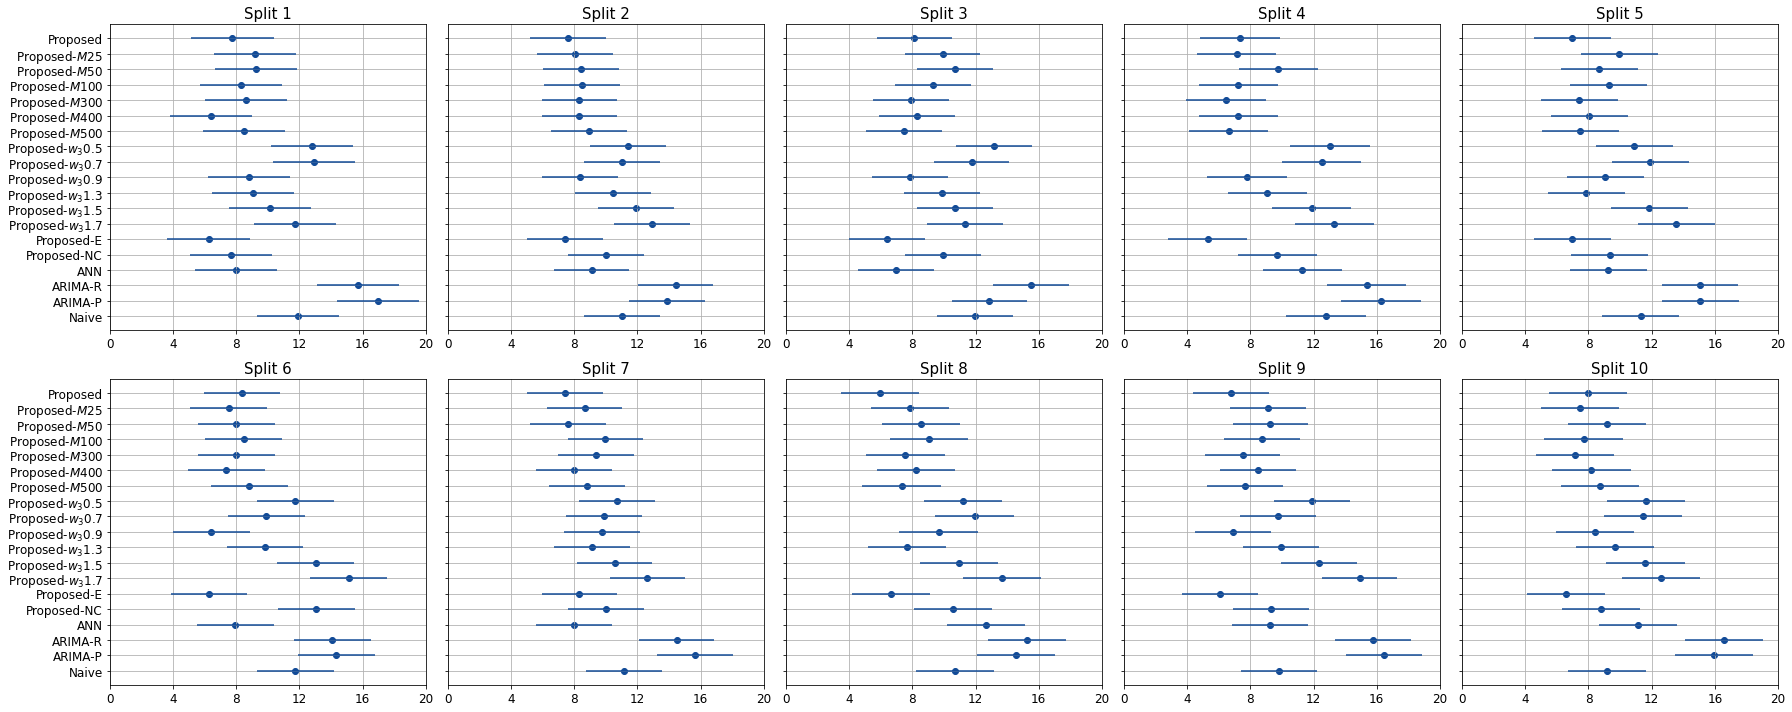

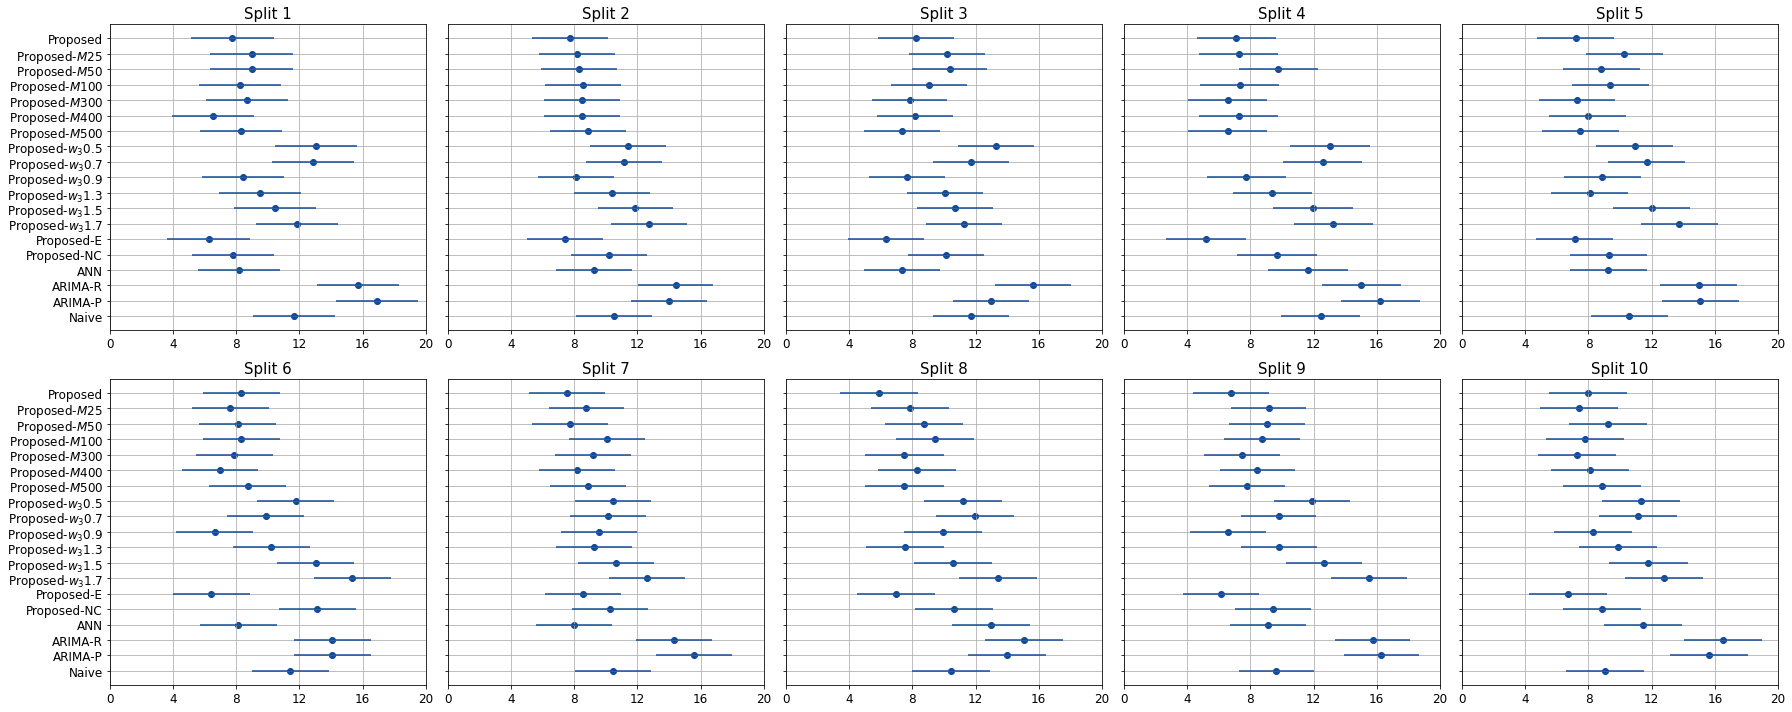

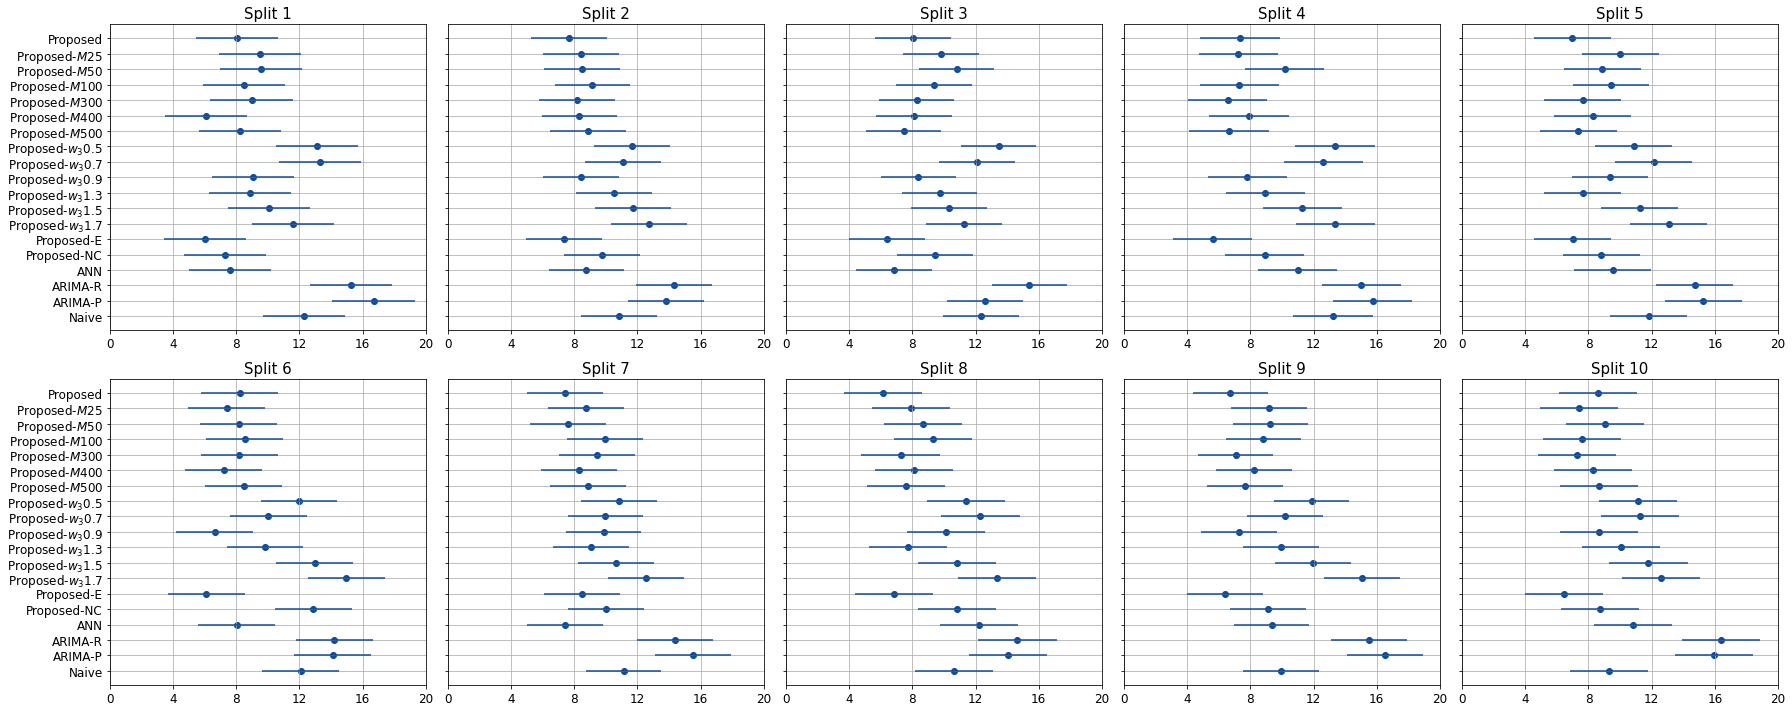

In [5]:
# MAPE
f, axes = plt.subplots(2, 5, figsize=(25, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

counter = 0
for rs in split_rs:
    
    df = pd.read_excel(current_dir+'/Analysis-all/MAPE/MAPE-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = df[['Proposed', 'Proposed-M25', 'Proposed-M50', 'Proposed-M100', 'Proposed-M300', 'Proposed-M400', 'Proposed-M500', 'Proposed-w30.5', 'Proposed-w30.7', 'Proposed-w30.9', 'Proposed-w31.3', 'Proposed-w31.5',
             'Proposed-w31.7', 'Proposed-E', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]

    rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
    for j in range(len(df)):
        rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')

    pvalue = scipy.stats.friedmanchisquare(df['Proposed'], df['Proposed-M25'], df['Proposed-M50'], df['Proposed-M100'], df['Proposed-M300'], df['Proposed-M400'], df['Proposed-M500'], 
                                           df['Proposed-w30.5'], df['Proposed-w30.7'], df['Proposed-w30.9'], df['Proposed-w31.3'], df['Proposed-w31.5'], df['Proposed-w31.7'], 
                                           df['Proposed-E'], df['Proposed-NC'], df['ANN'], df['ARIMA-R'], df['ARIMA-P'], df['Naive']).pvalue
    
    if pvalue <= 0.05:
        print(rs, 'MAPE', pvalue, 'Passed')
    else:
        print(rs, 'MAPE', pvalue, '======')
    
    CD = nemenyi_value(n_models, len(rank), q_alpha)
    rank_mean = list(rank.mean())
    interval_min = [x for x in rank_mean-CD/2]
    interval_max = [x for x in rank_mean+CD/2]

    rank.columns = ['Proposed', 'Proposed-$M$25', 'Proposed-$M$50', 'Proposed-$M$100', 'Proposed-$M$300', 'Proposed-$M$400', 'Proposed-$M$500', 
                    'Proposed-$w_3$0.5', 'Proposed-$w_3$0.7', 'Proposed-$w_3$0.9', 'Proposed-$w_3$1.3', 'Proposed-$w_3$1.5', 'Proposed-$w_3$1.7', 
                    'Proposed-E', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']

    axes_list[counter].scatter(rank_mean, rank.columns, color='#114A97')
    axes_list[counter].hlines(rank.columns, interval_min, interval_max, color='#114A97')
    axes_list[counter].set_xlim(0, 20)
    axes_list[counter].set_xticks(np.linspace(0,20,6))
    axes_list[counter].set_ylim(axes_list[counter].get_ylim()[::-1])
    axes_list[counter].tick_params(axis='both', which='major', labelsize=12)
    axes_list[counter].grid()
    axes_list[counter].set_title('Split '+str(counter+1), size=15)
    if (counter != 0) and (counter != 5):
        axes_list[counter].set_yticklabels('')
    counter += 1

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_9.png')

# MAE
f, axes = plt.subplots(2, 5, figsize=(25, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

counter = 0
for rs in split_rs:

    df = pd.read_excel(current_dir+'/Analysis-all/MAE/MAE-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = df[['Proposed', 'Proposed-M25', 'Proposed-M50', 'Proposed-M100', 'Proposed-M300', 'Proposed-M400', 'Proposed-M500', 'Proposed-w30.5', 'Proposed-w30.7', 'Proposed-w30.9', 'Proposed-w31.3', 'Proposed-w31.5',
             'Proposed-w31.7', 'Proposed-E', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]
    
    rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
    for j in range(len(df)):
        rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')

    pvalue = scipy.stats.friedmanchisquare(df['Proposed'], df['Proposed-M25'], df['Proposed-M50'], df['Proposed-M100'], df['Proposed-M300'], df['Proposed-M400'], df['Proposed-M500'], 
                                           df['Proposed-w30.5'], df['Proposed-w30.7'], df['Proposed-w30.9'], df['Proposed-w31.3'], df['Proposed-w31.5'], df['Proposed-w31.7'], 
                                           df['Proposed-E'], df['Proposed-NC'], df['ANN'], df['ARIMA-R'], df['ARIMA-P'], df['Naive']).pvalue
    
    if pvalue <= 0.05:
        print(rs, 'MAE', pvalue, 'Passed')
    else:
        print(rs, 'MAE', pvalue, '======')
    
    CD = nemenyi_value(n_models, len(rank), q_alpha)
    rank_mean = list(rank.mean())
    interval_min = [x for x in rank_mean-CD/2]
    interval_max = [x for x in rank_mean+CD/2]

    rank.columns = ['Proposed', 'Proposed-$M$25', 'Proposed-$M$50', 'Proposed-$M$100', 'Proposed-$M$300', 'Proposed-$M$400', 'Proposed-$M$500', 
                    'Proposed-$w_3$0.5', 'Proposed-$w_3$0.7', 'Proposed-$w_3$0.9', 'Proposed-$w_3$1.3', 'Proposed-$w_3$1.5', 'Proposed-$w_3$1.7', 
                    'Proposed-E', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']

    axes_list[counter].scatter(rank_mean, rank.columns, color='#114A97')
    axes_list[counter].hlines(rank.columns, interval_min, interval_max, color='#114A97')
    axes_list[counter].set_xlim(0, 20)
    axes_list[counter].set_xticks(np.linspace(0,20,6))
    axes_list[counter].set_ylim(axes_list[counter].get_ylim()[::-1])
    axes_list[counter].tick_params(axis='both', which='major', labelsize=12)
    axes_list[counter].grid()
    axes_list[counter].set_title('Split '+str(counter+1), size=15)
    if (counter != 0) and (counter != 5):
        axes_list[counter].set_yticklabels('')
    counter += 1

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_10.png')

# MR
f, axes = plt.subplots(2, 5, figsize=(25, 10))
ax1, ax2, ax3, ax4, ax5 = axes[0,0], axes[0,1], axes[0,2], axes[0,3], axes[0,4]
ax6, ax7, ax8, ax9, ax10 = axes[1,0], axes[1,1], axes[1,2], axes[1,3], axes[1,4]
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

counter = 0
for rs in split_rs:

    df = pd.read_excel(current_dir+'/Analysis-all/MR/MR-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = df[['Proposed', 'Proposed-M25', 'Proposed-M50', 'Proposed-M100', 'Proposed-M300', 'Proposed-M400', 'Proposed-M500', 'Proposed-w30.5', 'Proposed-w30.7', 'Proposed-w30.9', 'Proposed-w31.3', 'Proposed-w31.5',
             'Proposed-w31.7', 'Proposed-E', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]

    rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
    for j in range(len(df)):
        rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')

    pvalue = scipy.stats.friedmanchisquare(df['Proposed'], df['Proposed-M25'], df['Proposed-M50'], df['Proposed-M100'], df['Proposed-M300'], df['Proposed-M400'], df['Proposed-M500'], 
                                           df['Proposed-w30.5'], df['Proposed-w30.7'], df['Proposed-w30.9'], df['Proposed-w31.3'], df['Proposed-w31.5'], df['Proposed-w31.7'], 
                                           df['Proposed-E'], df['Proposed-NC'], df['ANN'], df['ARIMA-R'], df['ARIMA-P'], df['Naive']).pvalue
    
    if pvalue <= 0.05:
        print(rs, 'MR', pvalue, 'Passed')
    else:
        print(rs, 'MR', pvalue, '======')
    
    CD = nemenyi_value(n_models, len(rank), q_alpha)
    rank_mean = list(rank.mean())
    interval_min = [x for x in rank_mean-CD/2]
    interval_max = [x for x in rank_mean+CD/2]

    rank.columns = ['Proposed', 'Proposed-$M$25', 'Proposed-$M$50', 'Proposed-$M$100', 'Proposed-$M$300', 'Proposed-$M$400', 'Proposed-$M$500', 
                    'Proposed-$w_3$0.5', 'Proposed-$w_3$0.7', 'Proposed-$w_3$0.9', 'Proposed-$w_3$1.3', 'Proposed-$w_3$1.5', 'Proposed-$w_3$1.7', 
                    'Proposed-E', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']

    axes_list[counter].scatter(rank_mean, rank.columns, color='#114A97')
    axes_list[counter].hlines(rank.columns, interval_min, interval_max, color='#114A97')
    axes_list[counter].set_xlim(0, 20)
    axes_list[counter].set_xticks(np.linspace(0,20,6))
    axes_list[counter].set_ylim(axes_list[counter].get_ylim()[::-1])
    axes_list[counter].tick_params(axis='both', which='major', labelsize=12)
    axes_list[counter].grid()
    axes_list[counter].set_title('Split '+str(counter+1), size=15)
    if (counter != 0) and (counter != 5):
        axes_list[counter].set_yticklabels('')
    counter += 1

plt.tight_layout()
plt.savefig(current_dir+'/Figures/SuppFigure_11.png')

#### Figure 15

Global tests. Friedman test results are printed out as texts. Nemenyi test results are printed out as figures. Max and min values of the Nemenyi intervals are also printed out.

MAPE 1.363410853440736e-234 Passed
Min values of the intervals (MAPE) [6.655895857041553, 7.7157118079617995, 8.165098311029283, 7.8997608877164005, 7.059270090170387, 7.108349844771615, 7.264791562563026, 11.051601378513945, 10.496386654587566, 7.516325304894314, 8.496386654587566, 10.734116715937258, 12.40896334170413, 5.866018556428056, 9.097613648452596, 8.556202605507812, 14.433503219004743, 14.387490949066093, 10.359883587102903] 
Max values of the intervals (MAPE) [8.206067333142496, 9.265883284062742, 9.715269787130225, 9.449932363817343, 8.609441566271329, 8.658521320872557, 8.814963038663969, 12.601772854614888, 12.046558130688508, 9.066496780995257, 10.046558130688508, 12.2842881920382, 13.959134817805072, 7.416190032528998, 10.647785124553538, 10.106374081608754, 15.983674695105686, 15.937662425167035, 11.910055063203846]
MAE 7.664546163662346e-229 Passed
Min values of the intervals (MAE) [6.674300765017014, 7.798533893851369, 8.123687268084499, 7.930435734342167, 7.0439326

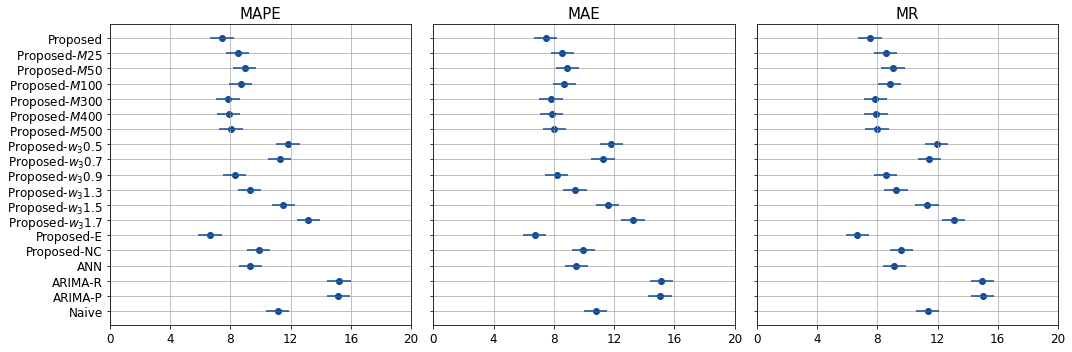

In [6]:
f, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1, ax2, ax3 = axes[0], axes[1], axes[2]
axes_list = [ax1, ax2, ax3]

# MAPE
df = pd.read_excel(current_dir+'/Analysis-all/MAPE/MAPE-'+str(split_rs[0])+'.xlsx', header = 0, sheet_name = 0)
for rs in split_rs[1:]:
    df_new = pd.read_excel(current_dir+'/Analysis-all/MAPE/MAPE-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = pd.concat((df, df_new))
df = df.reset_index(drop=True)
df = df[['Proposed', 'Proposed-M25', 'Proposed-M50', 'Proposed-M100', 'Proposed-M300', 'Proposed-M400', 'Proposed-M500', 'Proposed-w30.5', 'Proposed-w30.7', 'Proposed-w30.9', 'Proposed-w31.3', 'Proposed-w31.5',
         'Proposed-w31.7', 'Proposed-E', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]

rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
for j in range(len(df)):
    rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')

pvalue = scipy.stats.friedmanchisquare(df['Proposed'], df['Proposed-M25'], df['Proposed-M50'], df['Proposed-M100'], df['Proposed-M300'], df['Proposed-M400'], df['Proposed-M500'], 
                                       df['Proposed-w30.5'], df['Proposed-w30.7'], df['Proposed-w30.9'], df['Proposed-w31.3'], df['Proposed-w31.5'], df['Proposed-w31.7'], 
                                       df['Proposed-E'], df['Proposed-NC'], df['ANN'], df['ARIMA-R'], df['ARIMA-P'], df['Naive']).pvalue

rank.columns = ['Proposed', 'Proposed-$M$25', 'Proposed-$M$50', 'Proposed-$M$100', 'Proposed-$M$300', 'Proposed-$M$400', 'Proposed-$M$500', 
                'Proposed-$w_3$0.5', 'Proposed-$w_3$0.7', 'Proposed-$w_3$0.9', 'Proposed-$w_3$1.3', 'Proposed-$w_3$1.5', 'Proposed-$w_3$1.7', 
                'Proposed-E', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']

if pvalue <= 0.05:
    print('MAPE', pvalue, 'Passed')
else:
    print('MAPE', pvalue, '======')
    
CD = nemenyi_value(n_models, len(rank), q_alpha)
rank_mean = list(rank.mean())
interval_min = [x for x in rank_mean-CD/2]
interval_max = [x for x in rank_mean+CD/2]

print('Min values of the intervals (MAPE)', interval_min, '\nMax values of the intervals (MAPE)', interval_max)

ax1.scatter(rank_mean, rank.columns, color='#114A97')
ax1.hlines(rank.columns, interval_min, interval_max, color='#114A97')
ax1.set_xlim(0, 20)
ax1.set_xticks(np.linspace(0,20,6))
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid()
    
# MAE
df = pd.read_excel(current_dir+'/Analysis-all/MAE/MAE-'+str(split_rs[0])+'.xlsx', header = 0, sheet_name = 0)
for rs in split_rs[1:]:
    df_new = pd.read_excel(current_dir+'/Analysis-all/MAE/MAE-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = pd.concat((df, df_new))
df = df.reset_index(drop=True)
df = df[['Proposed', 'Proposed-M25', 'Proposed-M50', 'Proposed-M100', 'Proposed-M300', 'Proposed-M400', 'Proposed-M500', 'Proposed-w30.5', 'Proposed-w30.7', 'Proposed-w30.9', 'Proposed-w31.3', 'Proposed-w31.5',
         'Proposed-w31.7', 'Proposed-E', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]

rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
for j in range(len(df)):
    rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')

pvalue = scipy.stats.friedmanchisquare(df['Proposed'], df['Proposed-M25'], df['Proposed-M50'], df['Proposed-M100'], df['Proposed-M300'], df['Proposed-M400'], df['Proposed-M500'], 
                                       df['Proposed-w30.5'], df['Proposed-w30.7'], df['Proposed-w30.9'], df['Proposed-w31.3'], df['Proposed-w31.5'], df['Proposed-w31.7'], 
                                       df['Proposed-E'], df['Proposed-NC'], df['ANN'], df['ARIMA-R'], df['ARIMA-P'], df['Naive']).pvalue

rank.columns = ['Proposed', 'Proposed-$M$25', 'Proposed-$M$50', 'Proposed-$M$100', 'Proposed-$M$300', 'Proposed-$M$400', 'Proposed-$M$500', 
                'Proposed-$w_3$0.5', 'Proposed-$w_3$0.7', 'Proposed-$w_3$0.9', 'Proposed-$w_3$1.3', 'Proposed-$w_3$1.5', 'Proposed-$w_3$1.7', 
                'Proposed-E', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']

if pvalue <= 0.05:
    print('MAE', pvalue, 'Passed')
else:
    print('MAE', pvalue, '======')
    
CD = nemenyi_value(n_models, len(rank), q_alpha)
rank_mean = list(rank.mean())
interval_min = [x for x in rank_mean-CD/2]
interval_max = [x for x in rank_mean+CD/2]

print('Min values of the intervals (MAE)', interval_min, '\nMax values of the intervals (MAE)', interval_max)

ax2.scatter(rank_mean, rank.columns, color='#114A97')
ax2.hlines(rank.columns, interval_min, interval_max, color='#114A97')
ax2.set_xlim(0, 20)
ax2.set_xticks(np.linspace(0,20,6))
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_yticklabels('')
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.grid()

# MR
df = pd.read_excel(current_dir+'/Analysis-all/MR/MR-'+str(split_rs[0])+'.xlsx', header = 0, sheet_name = 0)
for rs in split_rs[1:]:
    df_new = pd.read_excel(current_dir+'/Analysis-all/MR/MR-'+str(rs)+'.xlsx', header = 0, sheet_name = 0)
    df = pd.concat((df, df_new))
df = df.reset_index(drop=True)
df = df[['Proposed', 'Proposed-M25', 'Proposed-M50', 'Proposed-M100', 'Proposed-M300', 'Proposed-M400', 'Proposed-M500', 'Proposed-w30.5', 'Proposed-w30.7', 'Proposed-w30.9', 'Proposed-w31.3', 'Proposed-w31.5',
         'Proposed-w31.7', 'Proposed-E', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']]

rank = pd.DataFrame(np.nan, index=list(df.index), columns=df.columns)
for j in range(len(df)):
    rank.iloc[j,:] = scipy.stats.rankdata(df.iloc[j,:], method='average')
    
pvalue = scipy.stats.friedmanchisquare(df['Proposed'], df['Proposed-M25'], df['Proposed-M50'], df['Proposed-M100'], df['Proposed-M300'], df['Proposed-M400'], df['Proposed-M500'], 
                                       df['Proposed-w30.5'], df['Proposed-w30.7'], df['Proposed-w30.9'], df['Proposed-w31.3'], df['Proposed-w31.5'], df['Proposed-w31.7'], 
                                       df['Proposed-E'], df['Proposed-NC'], df['ANN'], df['ARIMA-R'], df['ARIMA-P'], df['Naive']).pvalue

rank.columns = ['Proposed', 'Proposed-$M$25', 'Proposed-$M$50', 'Proposed-$M$100', 'Proposed-$M$300', 'Proposed-$M$400', 'Proposed-$M$500', 
                'Proposed-$w_3$0.5', 'Proposed-$w_3$0.7', 'Proposed-$w_3$0.9', 'Proposed-$w_3$1.3', 'Proposed-$w_3$1.5', 'Proposed-$w_3$1.7', 
                'Proposed-E', 'Proposed-NC', 'ANN', 'ARIMA-R', 'ARIMA-P', 'Naive']

if pvalue <= 0.05:
    print('MR', pvalue, 'Passed')
else:
    print('MR', pvalue, '======')
    
CD = nemenyi_value(n_models, len(rank), q_alpha)
rank_mean = list(rank.mean())
interval_min = [x for x in rank_mean-CD/2]
interval_max = [x for x in rank_mean+CD/2]

print('Min values of the intervals (MR)', interval_min, '\nMax values of the intervals (MR)', interval_max)

ax3.scatter(rank_mean, rank.columns, color='#114A97')
ax3.hlines(rank.columns, interval_min, interval_max, color='#114A97')
ax3.set_xlim(0, 20)
ax3.set_xticks(np.linspace(0,20,6))
ax3.set_ylim(ax3.get_ylim()[::-1])
ax3.set_yticklabels('')
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.grid()

ax1.set_title('MAPE', size=15)
ax2.set_title('MAE', size=15)
ax3.set_title('MR', size=15)

plt.tight_layout()
plt.savefig(current_dir+'/Figures/Figure_15.png')